# Pump It Up: Data Mining the Water Table 

Competition hosted by DrivenData 

## Import the dataset and relevant libraries 

In [26]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
from datetime import datetime
import sci_analysis as a
from fancyimpute import KNN

from random import randint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [27]:
%cd PumpItUp

[Errno 2] No such file or directory: 'PumpItUp'
/Users/Jackie/Desktop/PumpItUp


In [28]:
training_values = pd.read_csv('training_values.csv')
training_labels = pd.read_csv('training_labels.csv')
test_values = pd.read_csv('test_values.csv')

## Explore the data

What are we working with? Let's check out the features of this dataset and the labels for the waterpoints.

### Features

In [368]:
training_values.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [555]:
test_values.shape

(14850, 41)

In [315]:
training_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [316]:
training_values.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Labels

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


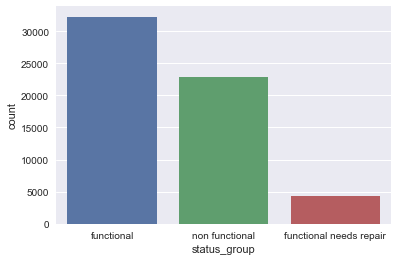

In [369]:
print(training_labels['status_group'].value_counts())
sns.countplot(x = 'status_group', data = training_labels)

In [620]:
training_labels[:5]

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


## Data Visualization

Here are some maps made using Tableau showing the labels for waterpoints around Tanzania.

### Map of all of the waterpoints in Tanzania. Color reflects the status of the waterpump and size reflects the population recorded using that waterpump. 

While it's nice to see the entire county, there are so many waterpoints that it might be nice to inspect a smaller area.

<img src="Waterpoint_Tanzania.png">

### Let's look at only the region of Mtwara

Here in Mtwara we can see a mix of functional, functional but need repair, and non functional waterpoints.

<img src="Waterpoint_Mtwara.png">

### Filter waterpoints to only show waterpoint types listed as "Other"

Now, we can see that the majority of waterpoints listed as "Other" are non functional even in places with large populations.

<img src="Waterpoint_Type_Other.png">

### Filter waterpoints to only show waterpoint types listed as "Communal Standpipe" 

Here we can see that the statuses of "Communal Standpipe" type of waterpoints is mixed.

<img src="Waterpoint_Type_Communal_Standpipe.png">

### The years that waterpoint data were collected 

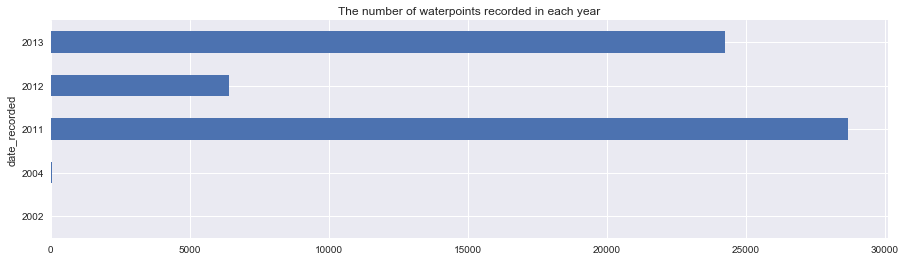

In [47]:
training_values['date_recorded'].groupby(training_values["date_recorded"].dt.year).count().plot(kind = "barh",
                                                    title = 'The number of waterpoints recorded in each year',
                                                    figsize = (15, 4))

## Feature Selection and Feature Engineering

Many of the features were exact replicas of other feature columns (quantity and quantity_group). Other features like amount_tsh had 0 listed for 70% of the data. I chose only to work with the features: 


In [29]:
# formatting the columns into categories and datetime

columns = ['district_code', 'extraction_type', 'quantity', 'source', 'public_meeting', 
           'waterpoint_type', 'funder', 'installer', 'extraction_type_class', 'permit', 'management', 
           'payment_type', 'water_quality', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by',
           'scheme_management', 'scheme_name', 'extraction_type_group', 'management_group', 'payment',
           'quality_group', 'source_type', 'source_class', 'waterpoint_type_group', 'wpt_name', 'quantity_group']

training_values[columns] = training_values[columns].apply(lambda x: x.astype('category'))
test_values[columns] = test_values[columns].apply(lambda x: x.astype('category'))

training_values['date_recorded'] = training_values['date_recorded'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
test_values['date_recorded'] = test_values['date_recorded'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

### longitude, latitude, and gps_height

There are 1812 timems that zero was entered for longitude. Everytime longitude was recorded as zero, latitude was recorded as -2.000000e-08, and gps_height was recorded as zero. 

To replace the zero values with something semi-accurate, I computed the mean longitude, mean latitude, and mean gps_height for each region and saved them to a dictionary. Then, when an instance of zero longitude was found, I replaced the longitude, latitude, and gps_height with the mean of the region that waterpoint existed.

In [30]:
# small region dataframe

region_df = training_values[['region_code', 'longitude', 'latitude', 'gps_height']].copy()
region_df = region_df.sort_values(['region_code'])
region_df[:5]

,region_code,longitude,latitude,gps_height
31023,1,36.040140,-4.729822,0
10601,1,36.479069,-6.174439,0
54054,1,36.489771,-7.104349,0
39734,1,35.830580,-4.381180,0
39723,1,35.993264,-7.026813,0


In [31]:
# calculates mean longitude, mean latitude, and mean gps_height for each region

def region_mean(df):
    old_region = None
    lats = []
    longs = []
    hts = []
    region_dict = {}
    
    for index, row in df.iterrows():
        this_region = int(row['region_code'])
        this_lat = float(row['latitude'])
        this_long = float(row['longitude'])
        this_ht = float(row['gps_height'])
        
        # if this is the first in a region
        if old_region and old_region != this_region:
            
            # printing out the previous region's mean_lat and mean_long
            mean_lat = float(np.mean(lats))
            mean_long = float(np.mean(longs))
            mean_ht = float(np.mean(hts))
            #print('%s mean lat: %f, mean long: %f' % (old_region, mean_lat, mean_long))
            region_dict[old_region] = {}
            region_dict[old_region]['mean_lat'] = mean_lat
            region_dict[old_region]['mean_long'] = mean_long
            region_dict[old_region]['mean_ht'] = mean_ht
            
            # reset mean_lat and mean_long
            lats = []
            longs = []
            hts = []
        
        # update region
        old_region = this_region
        
        # this region is the same as last region, append lats and longs
        lats.append(this_lat)
        longs.append(this_long)
        hts.append(this_ht)
        
    # print out very last region
    if old_region != None:
        mean_lat = float(np.mean(lats))
        mean_long = float(np.mean(longs))
        mean_ht = float(np.mean(hts))
        #print('%s mean lat: %f, mean long: %f' % (old_region, mean_lat, mean_long))
        region_dict[old_region] = {}
        region_dict[old_region]['mean_lat'] = mean_lat
        region_dict[old_region]['mean_long'] = mean_long
        region_dict[old_region]['mean_ht'] = mean_ht
        
    return region_dict

In [32]:
# make the dictionary

region_dict = region_mean(region_df)

In [33]:
# print an example of a dictionary entry

print(region_dict.get(2))

{'mean_lat': -3.231962549540344, 'mean_long': 36.648737683581345, 'mean_ht': 1393.4966931216932}


In [34]:
# function to replace the long, lat, and gps_height in the instances longitude equals zero

def replace_zeros(df, dictionary):
    
    for index, row in df.iterrows():
        region = int(row['region_code'])
        
        if row['longitude'] == 0.0:
            df.loc[index, 'longitude'] = region_dict.get(region).get('mean_long')
            df.loc[index, 'latitude'] = region_dict.get(region).get('mean_lat')
            df.loc[index, 'gps_height'] = region_dict.get(region).get('mean_ht')
            
    return df

In [35]:
# calling the replace_zeros function for the training and test sets

training_values = replace_zeros(training_values, region_dict)
test_values = replace_zeros(test_values, region_dict)

### date_recorded

The rainy season is in March, April, and May. Maybe if the waterpoint information was collected during one of those months is affects the label of the waterpoint. I added a month column using the date_recorded feature to determine if recording data during the rainy season made an impact on waterpoint status classification

https://www.expertafrica.com/tanzania/info/tanzania-weather-and-climate

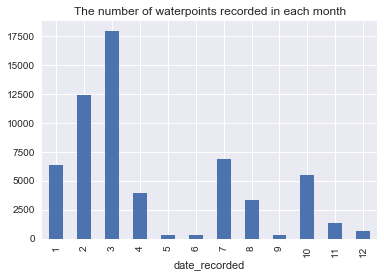

In [36]:
training_values['date_recorded'].groupby(training_values["date_recorded"].dt.month).count().plot(kind = "bar",
                                                    title = 'The number of waterpoints recorded in each month')

In [37]:
# creating the new column called month

training_values['month'] = 0
test_values['month'] = 0

# populating the month column with the month the waterpoint status information was collected
# this function takes a very long time to run -- need to find something faster

def find_month(df):
    
    for index, row in df.iterrows():
        date = df.loc[index, 'date_recorded']
        #year, month, day = str(date).split('-')
        df.loc[index, 'month'] = int(date.month)
            
    return df

In [38]:
# calling the find_month function for the training and test sets

training_values = find_month(training_values)
test_values = find_month(test_values)

training_values.month = training_values['month'].astype('category')
test_values.month = test_values['month'].astype('category')

### construction_year

There are 20709 instances of zero recorded as the construction year of the waterpoint in the training set.  

What can I do with all of the instances of zero? 

In [39]:
# we know that a zero for the construction_year is really a missing entry
# let's replace the zero values with NaN

training_values.construction_year = training_values['construction_year'].replace(0, np.NaN)
test_values.construction_year = test_values['construction_year'].replace(0, np.NaN)

/Users/Jackie/anaconda/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


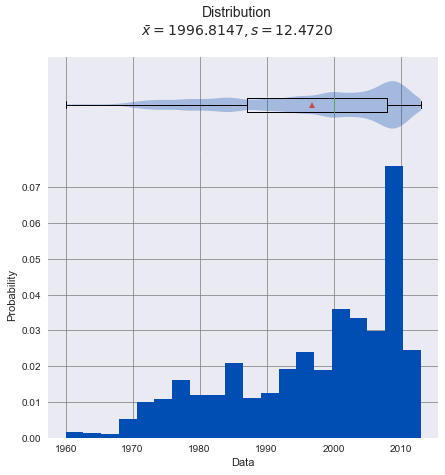

 
Statistics
----------
 
Count     =  38691
Mean      =  1996.8147
Std Dev   =  12.4720
Std Error =  0.0634
Skewness  = -0.7314
Kurtosis  = -0.5589
Maximum   =  2013.0000
75%       =  2008.0000
50%       =  2000.0000
25%       =  1987.0000
Minimum   =  1960.0000
IQR       =  21.0000
Range     =  53.0000
 
 
Shapiro-Wilk test for normality
-------------------------------
 
W value =  0.9086
p value =  0.0000
 
HA: Data is not normally distributed
 


In [46]:
a.analyze(training_values['construction_year'])

### population

Zero was entered 21381 times for population in the training set, I replaced the zeros in population with NaN

In [47]:
training_values.population = training_values['population'].replace(0, np.NaN)
test_values.population = test_values['population'].replace(0, np.NaN)

### gps_height

I chose to group the values of this feature by replacing the actual gps_height with a height range

In [48]:
training_values.gps_height = training_values.gps_height.apply(lambda x: '>500' if x > 500
                                                              else '0 to 500' if x > 0
                                                              else '0 or below')

test_values.gps_height = test_values.gps_height.apply(lambda x: '>500' if x > 500
                                                              else '0 to 500' if x > 0
                                                              else '0 or below')

training_values.gps_height = training_values.gps_height.astype('category')
test_values.gps_height = test_values.gps_height.astype('category')

### installer 

Replacing the 3655 times installer was entered as NaN with the mode.

In [49]:
training_values.installer = training_values['installer'].fillna(training_values['installer'].mode().iloc[0])
test_values.installer = test_values['installer'].fillna(training_values['installer'].mode().iloc[0])

### funder

Replacing the 3635 times funder was entered as NaN with the mode.

In [50]:
training_values.funder = training_values['funder'].fillna(training_values['funder'].mode().iloc[0])
test_values.funder = test_values['funder'].fillna(training_values['funder'].mode().iloc[0])

### permit

Replacing the 3056 times permit was entered as NaN with the mode.

In [51]:
training_values.permit = training_values['permit'].fillna(training_values['permit'].mode().iloc[0])
test_values.permit = test_values['permit'].fillna(training_values['permit'].mode().iloc[0])

### public_meeting

Replacing the 3334 times public_meeting was entered as NaN with False, assuming that a missing entry probably meant no meeting was ever recorded.

In [52]:
training_values.public_meeting = training_values['public_meeting'].fillna(False)
test_values.public_meeting = test_values['public_meeting'].fillna(False)

## Encoding Categorical features and splitting the data into training and test sets

In [100]:
X = training_values.drop(['id', 'amount_tsh', 'wpt_name', 'num_private', 'subvillage', 
                        'extraction_type_class', 'extraction_type_group', 'quality_group',
                        'quantity_group', 'source_class'], axis = 1)

y = training_labels['status_group']

X_test_data = test_values.drop(['id', 'amount_tsh', 'wpt_name', 'num_private', 'subvillage', 
                        'extraction_type_class', 'extraction_type_group', 'quality_group',
                        'quantity_group', 'source_class'], axis = 1)

In [102]:
columns = ['district_code', 'extraction_type', 'quantity', 'source', 'gps_height',  
           'public_meeting', 'waterpoint_type', 'funder', 'installer','month', 
           'permit', 'management', 'payment_type', 'water_quality', 'basin', 'region', 
           'lga', 'ward','recorded_by', 'scheme_management', 'scheme_name', 
           'management_group', 'payment', 'source_type', 'waterpoint_type_group']

X = pd.get_dummies(X[columns], dummy_na = True)
X_test_data = pd.get_dummies(X_test_data[columns], dummy_na = True)

X_test_data = X_test_data.reindex(columns = X.columns, fill_value=0)

In [103]:
print(X.shape)
print(X_test_data.shape)

(59400, 9154)
(14850, 9154)


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)

## Random Forest Classifier

In [105]:
rf_classifier = RandomForestClassifier(n_estimators = 60, criterion = 'entropy',
                                       min_samples_split = 6, 
                                       random_state = 6)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=1, oob_score=False, random_state=6,
            verbose=0, warm_start=False)

In [106]:
rf_y_pred = rf_classifier.predict(X_test)
rf_score = rf_classifier.score(X_test, y_test)
print('Random Forest Classifier Mean Accuracy:', rf_score)

Random Forest Classifier Mean Accuracy: 0.799607182941


## Make a prediction on the test data

In [149]:
predictions = rf_classifier.predict(X_test_data)

In [151]:
test_ids = np.array(test_values['id'].astype(int))
solution = pd.DataFrame(predictions, test_ids, columns = ['status_group'])

In [152]:
print(solution.head())
print(solution.shape)

         status_group
50785      functional
51630      functional
17168      functional
45559  non functional
49871      functional
(14850, 1)


In [153]:
solution.to_csv('solution4.csv', index_label = ['id'])